In [13]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

In [16]:
def generate_ROI(height1, width1, height2, width2):
    
    
    # ref 이미지의 가로 세로 비율
    ratio = height1/float(width1)
    #print(ratio)

    # x, y축 비율
    x_ratio = random.random()*0.35 + 0.15
    y_ratio = x_ratio*ratio
    #print('ratio: ', x_ratio, y_ratio)

    width = x_ratio*width1
    height = y_ratio*height1
    #print(width, height)

    # center point
    max_offset = 0.3
    cx_ratio = random.random()*max_offset - max_offset/2 + 0.5
    cy_ratio = random.random()*max_offset - max_offset/2 + 0.5
    cx = cx_ratio * width2
    cy = cy_ratio * height2
    #print('center: ', cx, cy)

    label = 0
    line = "{} {} {} {} {}".format(label, cx_ratio, cy_ratio, x_ratio, y_ratio)
    print(line)

    # bounding box
    pt1 = (int(cx-width/2), int(cy-height/2))
    pt2 = (int(pt1[0]+width), int(pt1[1]+height))
    print(pt1, pt2)
    
    return line, width, height, pt1, pt2

0 0.3918514841060915 0.5804354858691777 0.4712639226540436 0.5890799033175544
(53, 74) (147, 221)


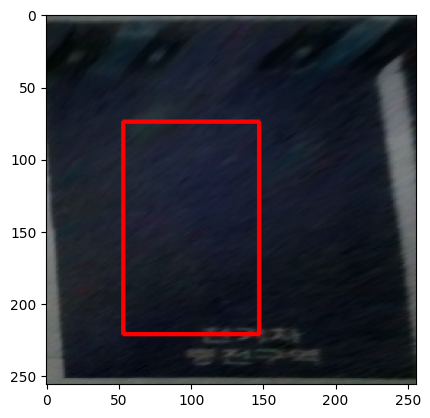

In [47]:
img1 = cv2.imread('여성전용/ref_img.png')
img2 = cv2.imread('empty_generated/EmptyType/Empty_type_4_empty1900_extend2352.jpg')

height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]
#print('1:', height1, width1, '2:', height2, width2)

# ROI 설정
line, width, height, pt1, pt2 = generate_ROI(height1, width1, height2, width2)

dst = cv2.rectangle(img2, pt1, pt2, (255, 0, 0), 2)

plt.imshow(dst)
#--⑦ 결과 출력
#cv2.imshow('bbox', dst)
#cv2.waitKey()
#cv2.destroyAllWindows()

In [48]:
# 이미지 전처리 - 노이즈, 투명도, 회전

# 변환 전 4개 좌표 
topLeft, topRight, bottomRight , bottomLeft = (0, 0), (width1, 0), (width1, height1), (0, height1)
print(topLeft, topRight, bottomRight , bottomLeft)

srcPoint = np.float32([topLeft, topRight, bottomRight , bottomLeft])

# 변환 후 4개 좌표
topLeft, topRight, bottomRight , bottomLeft = (0, 0), (width1, 0), (width1, height1), (0, height1)
print(topLeft, topRight, bottomRight , bottomLeft)
dstPoint = np.float32([topLeft, topRight, bottomRight , bottomLeft])

# Perspective transformation
matrix = cv2.getPerspectiveTransform(srcPoint, dstPoint)
print(matrix)
dst = cv2.warpPerspective(img1, matrix, (width, height))

(0, 0) (200, 0) (200, 250) (0, 250)


In [4]:
# https://fisher10001.tistory.com/101

#--② ROI 선택을 위한 좌표 계산
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]
x = (width2 - width1)//2
y = height2 - height1
w = x + width1
h = y + height1

#--③ 크로마키 배경 영상에서 크로마키 영역을 10픽셀 정도로 지정
chromakey = img1[:10, :10, :]
offset = 20

#--④ 크로마키 영역과 영상 전체를 HSV로 변경
hsv_chroma = cv2.cvtColor(chromakey, cv2.COLOR_BGR2HSV)
hsv_img = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

#--⑤ 크로마키 영역의 H값에서 offset 만큼 여유를 두어서 범위 지정
# offset 값은 여러차례 시도 후 결정
#chroma_h = hsv_chroma[0]
chroma_h = hsv_chroma[:,:,0]
lower = np.array([chroma_h.min()-offset, 100, 100])
upper = np.array([chroma_h.max()+offset, 255, 255])

#--⑥ 마스크 생성 및 마스킹 후 합성
mask = cv2.inRange(hsv_img, lower, upper)
mask_inv = cv2.bitwise_not(mask)
roi = img2[y:h, x:w]
fg = cv2.bitwise_and(img1, img1, mask=mask_inv)
bg = cv2.bitwise_and(roi, roi, mask=mask)
img2[y:h, x:w] = fg + bg

#--⑦ 결과 출력
cv2.imshow('chromakey', img1)
cv2.imshow('added', img2)
cv2.waitKey()
cv2.destroyAllWindows()